## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 4 - Estratégias de Treinamento e Transferência de Aprendizado</span>

#### <span style="color:darkred">**Parte 3: Visualização para Interpretação de Predições com GradCAM**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing.image import load_img
import cv2

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [315]:
(train_ds, validation_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[0%:50%]", "train[50%:55%]", "train[55%:60%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (128, 128)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,2)))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,2)))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,2)))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/home/maponti/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.68 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},

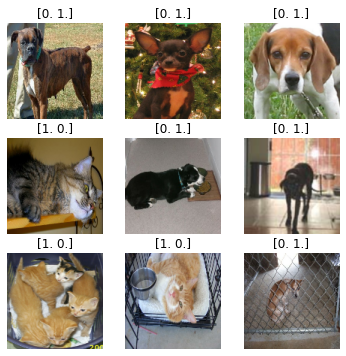

In [316]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(str(label.numpy()))
    plt.axis("off")

In [317]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=16)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=16)

--- 
### Carregando a CNN "MobileNet V2" com pesos pré-treinados


In [318]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_94[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [320]:
# remontando o modelo para permitir obter a saída da última camada além da predicao (abaixo)
extraction_model = keras.Model(
    inputs = [base_model.input],
    outputs = [base_model.get_layer('out_relu').output, base_model.output])

# Tornamos o modelo base não treinável, "congelando" os parâmetros
extraction_model.trainable = False

# Nosso modelo
inputs = keras.Input(shape=(128, 128, 3), name="input_layer")
# obtemos a referencia da camada e o valor a ser passado para a próxima camada 
out_mobilenet, x =  extraction_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(2, activation="softmax", name="predictions")(x) # essa será a única camada treinável
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_182 (Functional)       [(None, 4, 4, 1280), (Non 2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1280)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### Transferência de Aprendizado

In [321]:
model.compile(optimizer=keras.optimizers.Adam(0.0005),
    loss="categorical_crossentropy",  metrics=[keras.metrics.BinaryAccuracy()])

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/2
185/364 [==============>...............] - ETA: 14s - loss: 0.2438 - binary_accuracy: 0.8975

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/364 [=========================>....] - ETA: 2s - loss: 0.1925 - binary_accuracy: 0.9215

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/364 [===========================>..] - ETA: 1s - loss: 0.1871 - binary_accuracy: 0.9237

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


360/364 [============================>.] - ETA: 0s - loss: 0.1843 - binary_accuracy: 0.9249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


364/364 [==============================] - ETA: 0s - loss: 0.1832 - binary_accuracy: 0.9255

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


364/364 [==============================] - 29s 74ms/step - loss: 0.1832 - binary_accuracy: 0.9255 - val_loss: 0.0846 - val_binary_accuracy: 0.9673
Epoch 2/2
364/364 [==============================] - 11s 30ms/step - loss: 0.1051 - binary_accuracy: 0.9576 - val_loss: 0.0815 - val_binary_accuracy: 0.9690


In [322]:
extraction_model.trainable = True

model.compile( optimizer=keras.optimizers.Adam(0.00005), 
    loss="categorical_crossentropy", metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 3
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/3
364/364 [==============================] - 59s 154ms/step - loss: 0.0963 - binary_accuracy: 0.9623 - val_loss: 0.0921 - val_binary_accuracy: 0.9656
Epoch 2/3
364/364 [==============================] - 59s 162ms/step - loss: 0.0585 - binary_accuracy: 0.9782 - val_loss: 0.0633 - val_binary_accuracy: 0.9733
Epoch 3/3
364/364 [==============================] - 63s 172ms/step - loss: 0.0364 - binary_accuracy: 0.9862 - val_loss: 0.1253 - val_binary_accuracy: 0.9604


#### Visualização usando novas imagens

In [364]:
# funcao que permite expandir a dimensao da imagem para ficar de acordo com
# o tamanho da entrada da rede
def get_img_array(img):
    array = np.expand_dims(img, axis=0)
    return array

Text(0.5, 1.0, '[[0.009 0.991]]')

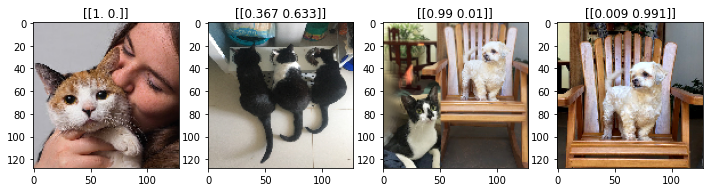

In [365]:
image1 = np.array(load_img("cathuman.jpg", target_size=(128, 128, 3)))/255.
image2 = np.array(load_img("gatos3.jpg", target_size=(128, 128, 3)))/255.
image4 = np.array(load_img("simon.jpg", target_size=(128, 128, 3)))/255.
image3 = np.array(load_img("nina_simon.jpg", target_size=(128, 128, 3)))/255.

fig = plt.figure(figsize=(12,4))
plt.subplot(141); plt.imshow(image1); plt.title(str(np.round(model.predict(get_img_array(image1)),3)))
plt.subplot(142); plt.imshow(image2); plt.title(str(np.round(model.predict(get_img_array(image2)),3)))
plt.subplot(143); plt.imshow(image3); plt.title(str(np.round(model.predict(get_img_array(image3)),3)))
plt.subplot(144); plt.imshow(image4); plt.title(str(np.round(model.predict(get_img_array(image4)),3)))

In [366]:
def grad_cam(image, model, out_layer, positive=True, clip=False):
    # cria modelo para gerar saída convolucional
    base_model = tf.keras.Model(model.inputs, out_layer)
    # pega entrada do modelo
    classifier_input = tf.keras.Input(shape=out_layer.shape[1:])
    
    x = classifier_input
    # gera modelo classificador com as duas camadas finais (sem dropout)
    for layer_name in ["avg_pool", "predictions"]:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # pedimos ao TensorFlow que monitore o tensor saída do modelo extrator
    # queremos calcular os gradientes das predicoes da classe alvo com respeito
    # a saída do modelo (base_model)
    with tf.GradientTape() as tape:
        last_layer_output = base_model(image)
        tape.watch(last_layer_output)
        preds = classifier_model(last_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    # computa gradiente (derivada parcial)
    # que codifica a forca da conexao dos pixels ao neuronio 
    # representando a classe alvo
    grads = tape.gradient(top_class_channel, last_layer_output)

    # opcao para exibir gradiente positivo 
    # ou sua inversa, regioes nao usadas na predicao da classe
    if positive:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    else:
        pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))
        
    last_layer_output = last_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_layer_output[:, :, i] *= pooled_grads[i]
        
    # media entre todos os mapas de ativacao
    gradcam = np.mean(last_layer_output, axis=-1)
    # remove valores negativos e normaliza 
    if clip: gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (128, 128))
    return gradcam

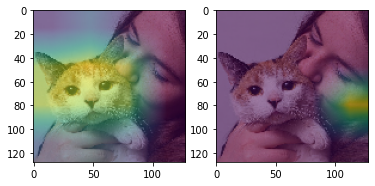

In [367]:
fig = plt.figure(figsize=(6,3))
gradcam1 = grad_cam(get_img_array(image1), model, out_mobilenet, positive=True, clip=True)
plt.subplot(121); plt.imshow(image1); plt.imshow(gradcam1, alpha=0.5)
gradcam1 = grad_cam(get_img_array(image1), model, out_mobilenet, positive=False, clip=True)
plt.subplot(122); plt.imshow(image1); plt.imshow(gradcam1, alpha=0.5)

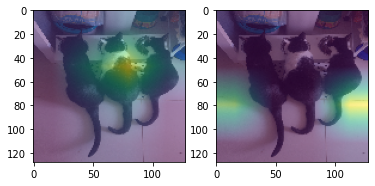

In [368]:
fig = plt.figure(figsize=(6,3))
gradcam2 = grad_cam(get_img_array(image2), model, out_mobilenet, positive=True, clip=True)
plt.subplot(121); plt.imshow(image2); plt.imshow(gradcam2, alpha=0.5)
gradcam2 = grad_cam(get_img_array(image2), model, out_mobilenet, positive=False, clip=True)
plt.subplot(122); plt.imshow(image2); plt.imshow(gradcam2, alpha=0.5)

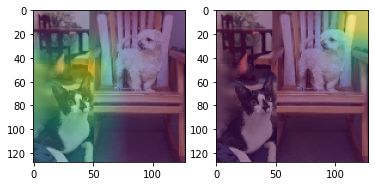

In [369]:
fig = plt.figure(figsize=(6,3))
gradcam3 = grad_cam(get_img_array(image3), model, out_mobilenet, positive=True, clip=True)
plt.subplot(121); plt.imshow(image3); plt.imshow(gradcam3, alpha=0.5)
gradcam3 = grad_cam(get_img_array(image3), model, out_mobilenet, positive=False, clip=True)
plt.subplot(122); plt.imshow(image3); plt.imshow(gradcam3, alpha=0.5)

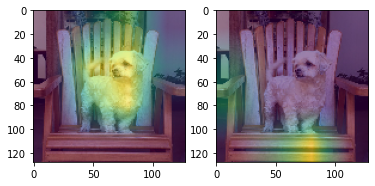

In [370]:
fig = plt.figure(figsize=(6,3))
gradcam4 = grad_cam(get_img_array(image4), model, out_mobilenet, positive=True, clip=True)
plt.subplot(121); plt.imshow(image4); plt.imshow(gradcam4, alpha=0.5)
gradcam4 = grad_cam(get_img_array(image4), model, out_mobilenet, positive=False, clip=True)
plt.subplot(122); plt.imshow(image4); plt.imshow(gradcam4, alpha=0.5)